In order to check the effectiveness of our model, we want to now how correlated our data is to gas. To do that we want a dataframe that holds all the data in a pairwise fasion (this means that the data points line up to one another), then we can check how correlated the data is.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime

from pytrends.request import TrendReq

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from graphviz import Digraph
from collections import deque
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)
kw = "Gas prices"
kw_list = [kw]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()


,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,6,False
2004-03-01,11,False
2004-04-01,10,False
2004-05-01,33,False


In [3]:
df_dji = pd.read_csv("data/DJI.csv") ## Reading DJI
df_sp500 = pd.read_csv('data/S&P500.csv')
file = pd.ExcelFile("data/GAS.xls")   ## Load the gas prices database
df_nas = pd.read_csv('data/NASDAQ.csv')

#Column selection
df_gas= file.parse('Data 1', header=2, ncolumns=2) # Parse the file, saving as our database
df_gas = df_gas[['Date', 'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df_gas = df_gas.rename(index=str, columns={"Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)": "gas_price"})
df_nas = df_nas[['Date', 'Close']]
df_interest = interest_df[['Gas prices']]
#Stocks
df_dji = df_dji[['Date', 'Close']]
df_sp500 = df_sp500[['Date', 'Close']]

#Dropping NaN values
df_gas.dropna(axis=0, inplace=True)
df_sp500.dropna(axis=0, inplace=True)
df_dji.dropna(axis=0, inplace=True)
df_nas.dropna(axis=0, inplace=True)

#Converting dates from string to datetime
df_dji['Date'] = pd.to_datetime(df_dji.Date)
df_sp500['Date'] = pd.to_datetime(df_sp500.Date)
df_gas['Date'] = pd.to_datetime(df_gas.Date)
df_nas['Date'] = pd.to_datetime(df_nas.Date)

#Set indexes
df_dji.set_index('Date', inplace = True)
df_gas.set_index('Date', inplace = True)
df_sp500.set_index('Date', inplace = True)
df_nas.set_index('Date', inplace = True)

#Rename Columns for our Master/Cross-Correlational Dataframe
df_dji = df_dji.rename(columns ={'Close': "DJI"})
df_sp500 = df_sp500.rename(columns ={'Close': "SP500"})
df_nas = df_nas.rename(columns ={'Close': "NASDAQ"})




In [4]:
#Upsampling Google Trends Data
upsample = df_interest.resample('D')
interpolated = upsample.interpolate(method='linear')
df_interest = interpolated

In [5]:
df_interest.head()

,Gas prices
date,
2004-01-01,5.000000
2004-01-02,5.032258
2004-01-03,5.064516
2004-01-04,5.096774
2004-01-05,5.129032


In [6]:
df_gas.head()

,gas_price
Date,
1993-04-05,1.068
1993-04-12,1.079
1993-04-19,1.079
1993-04-26,1.086
1993-05-03,1.086


In [7]:
df_dji.head()

,DJI
Date,
1985-01-29,1292.619995
1985-01-30,1287.880005
1985-01-31,1286.770020
1985-02-01,1277.719971
1985-02-04,1290.079956


In [8]:
df_sp500.head()

,SP500
Date,
1950-01-03,16.66
1950-01-04,16.85
1950-01-05,16.93
1950-01-06,16.98
1950-01-09,17.08


In [9]:
df_nas.head()

,NASDAQ
Date,
1971-02-05,100.000000
1971-02-08,100.839996
1971-02-09,100.760002
1971-02-10,100.690002
1971-02-11,101.449997


We can now combine these dataframes into one to get how correlated they are. So we want to join the dataframes on their dates so that they line up to do a pairwise comparision. Then we want to drop any null values so that they are do not affect the analysis.

In [10]:
df_corr = pd.concat([df_gas, df_dji, df_sp500, df_nas], axis=1, join_axes=[df_gas.index])
df_corr = df_corr.rename(columns={"gas_price": "Gas", "DJI": "Dow Jones", "SP500": "S&P 500"})
df_corr.dropna(axis=0, inplace = True)   #Drop null values
df_corr.head(10)




,Gas,Dow Jones,S&P 500,NASDAQ
Date,,,,
1993-04-05,1.068,3379.189941,442.290009,670.710022
1993-04-12,1.079,3428.090088,448.369995,673.119995
1993-04-19,1.079,3466.989990,447.459991,663.030029
1993-04-26,1.086,3398.370117,433.540009,645.869995
1993-05-03,1.086,3446.459961,442.459991,666.710022
1993-05-10,1.097,3443.280029,442.799988,682.820007
1993-05-17,1.106,3449.929932,440.369995,677.960022
1993-05-24,1.106,3507.780029,448.000000,694.690002
1993-06-07,1.104,3532.129883,447.690002,694.609985


In [11]:
##This is necessary because the indexes of Google Trends are not similar to that of the stock data, as the data begins in 2004.
df_corr_trends = pd.concat([df_gas, df_interest], axis=1, join_axes=[df_gas.index])
df_corr_trends = df_corr_trends.rename(columns={"gas_price": "Gas","Gas prices": "Google Trends"})
df_corr_trends.dropna(axis=0, inplace = True)   #Drop null values
len(df_corr_trends)

800

In [19]:
## Create 1D numpy arrays from dataframe columns
dji_array = df_corr['Dow Jones'].values
SP500_array = df_corr['S&P 500'].values
NASDAQ_array = df_corr['NASDAQ'].values
gas_array = df_corr['Gas'].values
trends_array = df_corr_trends['Google Trends'].values
print(dji_array.shape, SP500_array.shape, NASDAQ_array.shape, gas_array.shape, trends_array.shape)

(1235,) (1235,) (1235,) (1235,) (800,)


In [30]:
## Difference the data to get a stationary time series
dji_array = np.diff(dji_array)
SP500_array = np.diff(SP500_array)
NASDAQ_array = np.diff(NASDAQ_array)
gas_array = np.diff(gas_array)
trends_array = np.diff(trends_array)

## Normalize the values by subtracting each value by the minimum and then dividing by the range of the data
for i in range(len(dji_array)):
    dji_array[i] = (dji_array[i] - dji_array.min()) / (dji_array.max() - dji_array.min())
    SP500_array[i] = (SP500_array[i] - SP500_array.min()) / (SP500_array.max() - SP500_array.min())
    NASDAQ_array[i] = (NASDAQ_array[i] - NASDAQ_array.min()) / (NASDAQ_array.max() - NASDAQ_array.min())
    gas_array[i] = (gas_array[i] - gas_array.min()) / (gas_array.max() - gas_array.min())

for i in range(len(trends_array)):
    trends_array = np.divide(trends_array, trends_array.max())

corr_dji = sp.signal.correlate(dji_array, gas_array)
corr_NASDAQ = sp.signal.correlate(NASDAQ_array, gas_array)
corr_SP500 = sp.signal.correlate(SP500_array, gas_array)
corr_trends = sp.signal.correlate(trends_array, gas_array)

## Cross Correlation

We plotted the cross-correlation between all stock data and google trends data to gas prices. The cross-correlation is roughly normally distributed.

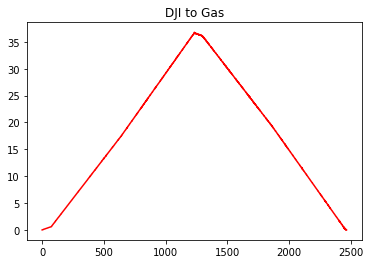

In [31]:
plt.plot(corr_dji, color = 'r'); plt.title('DJI to Gas')
plt.show()

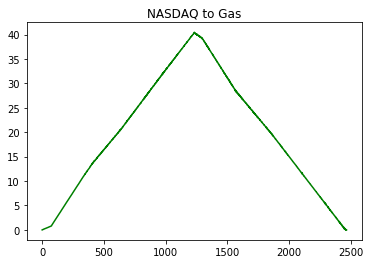

In [32]:
plt.plot(corr_NASDAQ, color = 'g'); plt.title('NASDAQ to Gas')
plt.show()

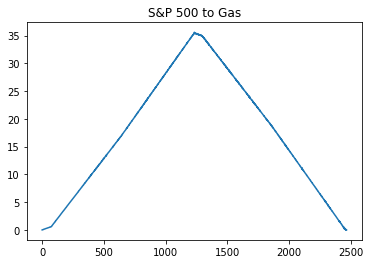

In [33]:
plt.plot(corr_SP500); plt.title('S&P 500 to Gas')
plt.show()

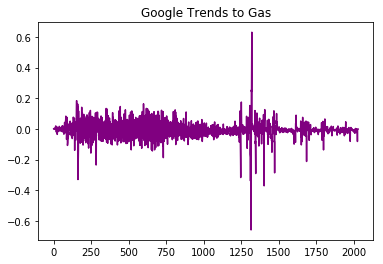

In [34]:
plt.plot(corr_trends, color = 'purple'); plt.title('Google Trends to Gas')
plt.show()